In [10]:
import os
import sys
os.environ["PYSPARK_SUBMIT_ARGS"]='--packages com.databricks:spark-csv_2.10:1.2.0 pyspark-shell --num-executors 5'
os.environ["PYSPARK_PYTHON"]='python3'
os.environ["SPARK_HOME"]='/usr/hdp/current/spark2-client'

spark_home = os.environ.get('SPARK_HOME', None)
if not spark_home:
    raise ValueError('SPARK_HOME environment variable is not set')
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.6-src.zip'))
os.environ["PYSPARK_PYTHON"] = 'python3'
exec(open(os.path.join(spark_home, 'python/pyspark/shell.py')).read())
import re

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.3.0
      /_/

Using Python version 3.6.4 (default, Jan 28 2018 00:00:00)
SparkSession available as 'spark'.


In [11]:
ids = [15516,22777,13131,5660,965,877]

In [12]:
#подгружаем все что нам понадобится
from pyspark.conf import SparkConf
spark=SparkSession.builder.config(conf=SparkConf()).getOrCreate()

from pyspark.sql.functions import col

import re
from pyspark.sql.functions import udf

from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import Normalizer

import numpy as np
from pyspark.ml.linalg import *
from pyspark.sql.types import * 
from pyspark.sql.functions import *
from pyspark.sql.functions import udf

import json

In [13]:
#читаем данные
sqlContext = SQLContext (sc)
dataInit = sqlContext.read.json("/labs/lab07data/DO_record_per_line.json")

In [14]:
print(dataInit.columns)
print(dataInit.select('lang').distinct().count())

['cat', 'desc', 'id', 'lang', 'name', 'provider']
35


In [15]:
 [[877, 0.1], [965, 0.1], [5660, 0.8], [13131, 0.2], [15516, 0.8], [22777, 0.8]]
    
[[877, 0.1], [965, 0.1], [5660, 0.8], [13131, 0.1], [15516, 0.4], [22777, 0.8]]

[[877, 0.1], [965, 0.1], [5660, 0.8], [13131, 0.1], [15516, 0.4], [22777, 0.8]]

In [16]:
dataInit.where(col('id').isin(ids)).select('name','lang','id').show()

+--------------------+----+-----+
|                name|lang|   id|
+--------------------+----+-----+
|Нейрокомпьютинг и...|  ru|  877|
|Основы работы с G...|  ru|  965|
|Escritura Emocion...|  es| 5660|
|Instala Google An...|  es|13131|
|Optimizing Perfor...|  en|15516|
|Attract High Payi...|  en|22777|
+--------------------+----+-----+



In [17]:
dataInit.where(col('id').isin('6235','6234', '6149', '16328', '20217', '26624', '14505', '17495', '26999', '25969', '24248'))\
.select('name','lang','id').show()

+--------------------+----+-----+
|                name|lang|   id|
+--------------------+----+-----+
|Regular Expressio...|  en| 6149|
|Learn Medical Mar...|  en| 6234|
| Medicinal Marijuana|  en| 6235|
|Drawing on the iP...|  en|14505|
|Using Regular Exp...|  en|16328|
|Learning Regular ...|  en|17495|
|The Patient-to-Pa...|  en|20217|
|JavaScript from s...|  en|24248|
|Lazy Ninja's Guid...|  en|25969|
|How I made $1800 ...|  en|26624|
|Get the job YOU w...|  en|26999|
+--------------------+----+-----+



In [18]:
dataInit.first()

Row(cat='3/business_management|6/economics_finance', desc='This course introduces the basic financial statements used by most businesses, as well as the essential tools used to prepare them. This course will serve as a resource to help business students succeed in their upcoming university-level accounting classes, and as a refresher for upper division accounting students who are struggling to recall elementary concepts essential to more advanced accounting topics. Business owners will also benefit from this class by gaining essential skills necessary to organize and manage information pertinent to operating their business. At the conclusion of the class, students will understand the balance sheet, income statement, and cash flow statement. They will be able to differentiate between cash basis and accrual basis techniques, and know when each is appropriate. They’ll also understand the accounting equation, how to journalize and post transactions, how to adjust and close accounts, and ho

In [19]:
lang=dataInit.groupby('lang').count().sort('count')
lang.show(100)

+----+-----+
|lang|count|
+----+-----+
|  ms|    1|
|  uz|    1|
|  sv|    1|
|  pl|    1|
|  et|    1|
|  sw|    1|
|  fa|    1|
|  vi|    1|
|  id|    1|
|  bg|    2|
|  af|    2|
|  hu|    2|
|  nb|    2|
|  fi|    2|
|  ko|    3|
|  da|    3|
|  hr|    4|
|  sk|    5|
|  el|    5|
|  hi|    6|
|  nl|    6|
|  ca|    6|
|  he|    8|
|  ur|   11|
|  ar|   34|
|  it|   62|
|  ja|   77|
|  fr|  104|
|  tr|  120|
|  de|  166|
|  zh|  169|
|  pt|  187|
|  ru| 1231|
|  es| 1374|
|  en|24553|
+----+-----+



In [20]:
lang_list=lang.rdd.map(lambda Row: {'lang':Row[0],'count':Row[1]}).collect()
lang_list

[{'count': 1, 'lang': 'vi'},
 {'count': 1, 'lang': 'uz'},
 {'count': 1, 'lang': 'sw'},
 {'count': 1, 'lang': 'id'},
 {'count': 1, 'lang': 'pl'},
 {'count': 1, 'lang': 'ms'},
 {'count': 1, 'lang': 'sv'},
 {'count': 1, 'lang': 'fa'},
 {'count': 1, 'lang': 'et'},
 {'count': 2, 'lang': 'bg'},
 {'count': 2, 'lang': 'nb'},
 {'count': 2, 'lang': 'hu'},
 {'count': 2, 'lang': 'fi'},
 {'count': 2, 'lang': 'af'},
 {'count': 3, 'lang': 'ko'},
 {'count': 3, 'lang': 'da'},
 {'count': 4, 'lang': 'hr'},
 {'count': 5, 'lang': 'sk'},
 {'count': 5, 'lang': 'el'},
 {'count': 6, 'lang': 'hi'},
 {'count': 6, 'lang': 'nl'},
 {'count': 6, 'lang': 'ca'},
 {'count': 8, 'lang': 'he'},
 {'count': 11, 'lang': 'ur'},
 {'count': 34, 'lang': 'ar'},
 {'count': 62, 'lang': 'it'},
 {'count': 77, 'lang': 'ja'},
 {'count': 104, 'lang': 'fr'},
 {'count': 120, 'lang': 'tr'},
 {'count': 166, 'lang': 'de'},
 {'count': 169, 'lang': 'zh'},
 {'count': 187, 'lang': 'pt'},
 {'count': 1231, 'lang': 'ru'},
 {'count': 1374, 'lang': '

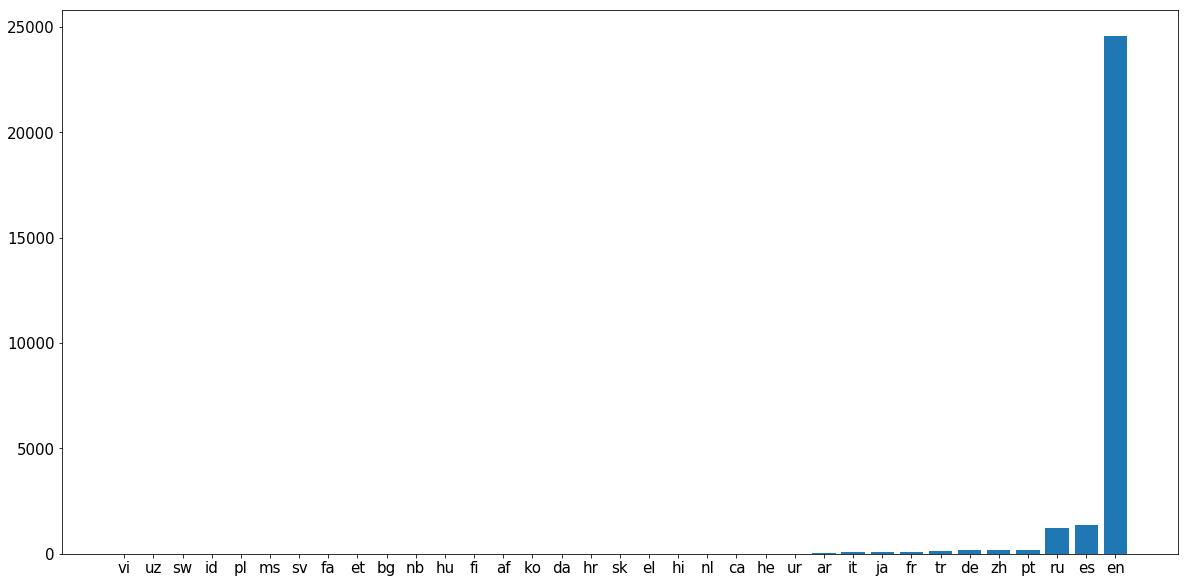

In [21]:
import matplotlib.pyplot as plt

vals=[]
names=[]
for i in lang_list:
    vals.append(i.get('count'))
    names.append(i.get('lang'))

plt.figure(figsize=(20,10))
plt.bar(range(35),vals)
plt.xticks(range(35),names)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.show()

In [22]:
langs=['en','ru','es']

#data_ru_eng=dataInit.where(col('lang').isin(langs))
dataToprocess=dataInit.withColumn('description', concat(col('name'), lit(' '), col('desc')))
dataToprocess.select('description').first()

Row(description='Accounting Cycle: The Foundation of Business Measurement and Reporting This course introduces the basic financial statements used by most businesses, as well as the essential tools used to prepare them. This course will serve as a resource to help business students succeed in their upcoming university-level accounting classes, and as a refresher for upper division accounting students who are struggling to recall elementary concepts essential to more advanced accounting topics. Business owners will also benefit from this class by gaining essential skills necessary to organize and manage information pertinent to operating their business. At the conclusion of the class, students will understand the balance sheet, income statement, and cash flow statement. They will be able to differentiate between cash basis and accrual basis techniques, and know when each is appropriate. They’ll also understand the accounting equation, how to journalize and post transactions, how to adju

In [23]:
dataToprocess.show(2)

+--------------------+--------------------+---+----+--------------------+--------------+--------------------+
|                 cat|                desc| id|lang|                name|      provider|         description|
+--------------------+--------------------+---+----+--------------------+--------------+--------------------+
|3/business_manage...|This course intro...|  4|  en|Accounting Cycle:...|Canvas Network|Accounting Cycle:...|
|              11/law|This online cours...|  5|  en|American Counter ...|Canvas Network|American Counter ...|
+--------------------+--------------------+---+----+--------------------+--------------+--------------------+
only showing top 2 rows



In [24]:
#парсим
regex = re.compile(r'[\w\d]{2,}', re.U)
#regex.findall(string.lower())
           
F1 = udf(lambda x: ' '.join(regex.findall(x.lower())))

texts = dataInit.withColumn("clean" ,F1(dataInit["desc"])).select('id','clean','lang')

texts.show(10)

+---+--------------------+----+
| id|               clean|lang|
+---+--------------------+----+
|  4|this course intro...|  en|
|  5|this online cours...|  en|
|  6|this course is ta...|  fr|
|  7|we live in digita...|  en|
|  8|this self paced c...|  en|
|  9|this game based c...|  en|
| 10|what in your digi...|  en|
| 11|the goal of the d...|  en|
| 12|ready to explore ...|  en|
| 13|this self paced c...|  en|
+---+--------------------+----+
only showing top 10 rows



In [25]:
texts.select('clean').first()

Row(clean='this course introduces the basic financial statements used by most businesses as well as the essential tools used to prepare them this course will serve as resource to help business students succeed in their upcoming university level accounting classes and as refresher for upper division accounting students who are struggling to recall elementary concepts essential to more advanced accounting topics business owners will also benefit from this class by gaining essential skills necessary to organize and manage information pertinent to operating their business at the conclusion of the class students will understand the balance sheet income statement and cash flow statement they will be able to differentiate between cash basis and accrual basis techniques and know when each is appropriate they ll also understand the accounting equation how to journalize and post transactions how to adjust and close accounts and how to prepare key financial reports all material for this class is 

In [26]:
tokenizer = Tokenizer(inputCol="clean", outputCol="words" , )
tempData = tokenizer.transform(texts)

hashingTF = HashingTF(inputCol="words", outputCol="hashing_TF", numFeatures=8000)
featurizedData = hashingTF.transform(tempData)
featurizedData.cache()
idf = IDF(inputCol="hashing_TF", outputCol="tf_idf")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

normalizer = Normalizer(inputCol="tf_idf", outputCol="normFeatures", p=1.0)
l1NormData = normalizer.transform(rescaledData)
print("Normalized using L^1 norm")
l1NormData.show(10)

Normalized using L^1 norm
+---+--------------------+----+--------------------+--------------------+--------------------+--------------------+
| id|               clean|lang|               words|          hashing_TF|              tf_idf|        normFeatures|
+---+--------------------+----+--------------------+--------------------+--------------------+--------------------+
|  4|this course intro...|  en|[this, course, in...|(8000,[48,164,177...|(8000,[48,164,177...|(8000,[48,164,177...|
|  5|this online cours...|  en|[this, online, co...|(8000,[0,32,37,48...|(8000,[0,32,37,48...|(8000,[0,32,37,48...|
|  6|this course is ta...|  fr|[this, course, is...|(8000,[65,118,375...|(8000,[65,118,375...|(8000,[65,118,375...|
|  7|we live in digita...|  en|[we, live, in, di...|(8000,[13,346,572...|(8000,[13,346,572...|(8000,[13,346,572...|
|  8|this self paced c...|  en|[this, self, pace...|(8000,[32,61,77,1...|(8000,[32,61,77,1...|(8000,[32,61,77,1...|
|  9|this game based c...|  en|[this, game, ba

In [27]:
#ngram = NGram(n=2, inputCol="words", outputCol="ngrams")

NameError: name 'NGram' is not defined

In [28]:
myData=l1NormData.select('id','hashing_TF','normFeatures','lang')
myData.cache()
myData.write.save("lab_07s_tfidf_8000.parquet")

In [29]:
myData = spark.read.load("lab_07s_tfidf_8000.parquet")
myData.show(10)

+---+--------------------+--------------------+----+
| id|          hashing_TF|        normFeatures|lang|
+---+--------------------+--------------------+----+
|  4|(8000,[48,164,177...|(8000,[48,164,177...|  en|
|  5|(8000,[0,32,37,48...|(8000,[0,32,37,48...|  en|
|  6|(8000,[65,118,375...|(8000,[65,118,375...|  fr|
|  7|(8000,[13,346,572...|(8000,[13,346,572...|  en|
|  8|(8000,[32,61,77,1...|(8000,[32,61,77,1...|  en|
|  9|(8000,[217,308,39...|(8000,[217,308,39...|  en|
| 10|(8000,[537,580,14...|(8000,[537,580,14...|  en|
| 11|(8000,[208,572,75...|(8000,[208,572,75...|  en|
| 12|(8000,[140,465,62...|(8000,[140,465,62...|  en|
| 13|(8000,[1239,1354,...|(8000,[1239,1354,...|  en|
+---+--------------------+--------------------+----+
only showing top 10 rows



CALCULATE COS SIM 

ids для lab07:

In [ ]:
ids=[[24664, u'en', u'Mastering Magento - Udemy']\
     , [23983, u'en', u'How to Price your Product & Service and Charge for Profit.']\
     , [11574, u'es', u'Aprender a escribir a los 4: M\xe9todo Doman en Preescolar by Elisa Guerra']\
     , [12801, u'es', u'Aprende a tocar blues en el piano y teclado by Virtuosso Producciones']\
     , [25922, u'ru', u'\u0414\u0438\u043d\u0430\u0441\u0442\u0438\u0447\u0435\u0441\u043a\u0438\u0439 \u043c\u0438\u0440 \u0434\u043e\u043c\u043e\u043d\u0433\u043e\u043b\u044c\u0441\u043a\u043e\u0439 \u0420\u0443\u0441\u0438']\
     , [1178, u'ru', u'\u0420\u0430\u0431\u043e\u0442\u0430 \u0432 Microsoft Excel XP']]
ids=sorted([x[0] for x in ids])
print(ids)

для ачивки:

In [ ]:
ids=[[6235, u'en', u'Medicinal Marijuana']\
     , [9209, u'en', u'Cable TV Installer Training by David Deke']\
     , [9416, u'es', u'Curso de preparacion para la mujer embarazada by Daniela Becerra Morales']\
     , [5750, u'es', u'Administre Proyectos Efectivamente - Curso de Fundamentos by Projectical S.A.S. REP del PMI']\
     , [1387, u'ru', u'\u0412\u0432\u0435\u0434\u0435\u043d\u0438\u0435 \u0432 \u0442\u0435\u043e\u0440\u0438\u044e \u043f\u0440\u043e\u0433\u0440\u0430\u043c\u043c\u0438\u0440\u043e\u0432\u0430\u043d\u0438\u044f. \u041e\u0431\u044a\u0435\u043a\u0442\u043d\u043e-\u043e\u0440\u0438\u0435\u043d\u0442\u0438\u0440\u043e\u0432\u0430\u043d\u043d\u044b\u0439 \u043f\u043e\u0434\u0445\u043e\u0434']\
     , [8787, u'ru', u'\u0424\u0438\u0437\u0438\u043a\u0430. \u041a\u0432\u0430\u043d\u0442\u043e\u0432\u0430\u044f \u0444\u0438\u0437\u0438\u043a\u0430. \u041b\u0435\u043a\u0446\u0438\u0438']]
ids=sorted([x[0] for x in ids])
print(ids)

In [ ]:
myData.filter(col('id').isin(ids)).show()

In [ ]:
course_1=myData.where(col('id')==int(ids[0])).select('normFeatures').collect()[0][0]
course_2=myData.where(col('id')==int(ids[1])).select('normFeatures').collect()[0][0]
course_3=myData.where(col('id')==int(ids[2])).select('normFeatures').collect()[0][0]
course_4=myData.where(col('id')==int(ids[3])).select('normFeatures').collect()[0][0]
course_5=myData.where(col('id')==int(ids[4])).select('normFeatures').collect()[0][0]
course_6=myData.where(col('id')==int(ids[5])).select('normFeatures').collect()[0][0]

In [ ]:
course_3

In [ ]:
def cos_sim_sp(a,b):
    
    if a.norm(2) !=0 and a.norm(2) !=0:
        res=a.dot(b)/(a.norm(2) *b.norm(2))
    else:
        res=0 
    return float(res)

def cos_sim(a,b):
    if np.linalg.norm(a) !=0 and np.linalg.norm(b) !=0:
        res=float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))
    else:
        res=0
    return res

def square_list(x):
    return [float(val)**2 for val in x]

In [ ]:
print(cos_sim(course_4,course_5))
print(cos_sim_sp(course_4, course_5))

In [ ]:
fun_cos = udf(lambda x:cos_sim_sp(x,course_1), FloatType())
ccourse_1_res=list(myData.withColumn("similarity", fun_cos(myData['normFeatures']))\
                   .select('id','similarity')\
                   .orderBy('similarity', ascending=False)\
                   .limit(11)\
                   .toPandas()['id'][1:10])

In [ ]:
fun_cos = udf(lambda x:cos_sim_sp(x,course_2), FloatType())
ccourse_2_res=list(myData.withColumn("similarity", fun_cos(myData['normFeatures']))\
                   .select('id','similarity')\
                   .orderBy('similarity', ascending=False)\
                   .limit(11)\
                   .toPandas()['id'][1:10])

In [ ]:
#myData.where(col('lang')=='en'
#т.к. чекер изначально выдал %% совпадения 20, а надо min(30), то ограничим поиск схожих среди ('lang')=='en'
fun_cos = udf(lambda x:cos_sim_sp(x,course_3), FloatType())
ccourse_3_res=list(myData.where(col('lang')=='en').withColumn("similarity", fun_cos(myData['normFeatures']))\
                   .select('id','similarity')\
                   .orderBy('similarity', ascending=False)\
                   .limit(11)\
                   .toPandas()['id'][1:10])

In [ ]:
fun_cos = udf(lambda x:cos_sim_sp(x,course_4), FloatType())
ccourse_4_res=list(myData.withColumn("similarity", fun_cos(myData['normFeatures']))\
                   .select('id','similarity')\
                   .orderBy('similarity', ascending=False)\
                   .limit(11)\
                   .toPandas()['id'][1:10])

In [ ]:
fun_cos = udf(lambda x:cos_sim_sp(x,course_5), FloatType())
ccourse_5_res=list(myData.withColumn("similarity", fun_cos(myData['normFeatures']))\
                   .select('id','similarity')\
                   .orderBy('similarity', ascending=False)\
                   .limit(11)\
                   .toPandas()['id'][1:10])

In [ ]:
fun_cos = udf(lambda x:cos_sim_sp(x,course_6), FloatType())
ccourse_6_res=list(myData.withColumn("similarity", fun_cos(myData['normFeatures']))\
                   .select('id','similarity')\
                   .orderBy('similarity', ascending=False)\
                   .limit(11)\
                   .toPandas()['id'][1:10])

In [ ]:
myData.where(col('id').isin(ids)).select('normFeatures','id').show()

In [ ]:
# ccourse_1_res=[x.item() for x in ccourse_1_res]
# ccourse_2_res=[x.item() for x in ccourse_2_res]
# ccourse_3_res=[x.item() for x in ccourse_3_res]
# ccourse_4_res=[x.item() for x in ccourse_4_res]
# ccourse_5_res=[x.item() for x in ccourse_5_res]
# ccourse_6_res=[x.item() for x in ccourse_6_res]


ccourse_1_res=[int(x) for x in ccourse_1_res]
ccourse_2_res=[int(x) for x in ccourse_2_res]
ccourse_3_res=[int(x) for x in ccourse_3_res]
ccourse_4_res=[int(x) for x in ccourse_4_res]
ccourse_5_res=[int(x) for x in ccourse_5_res]
ccourse_6_res=[int(x) for x in ccourse_6_res]

In [ ]:
result = {int(ids[0]): ccourse_1_res,
          int(ids[1]): ccourse_2_res,
          int(ids[2]): ccourse_3_res,
          int(ids[3]): ccourse_4_res,
          int(ids[4]): ccourse_5_res,
          int(ids[5]): ccourse_6_res}

with open('lab07s.json', 'w') as f:
    json.dump(result, f)

In [ ]:
sc.stop()